#CNN Cancer Detection Kaggle Mini-Project
This project explores creating a Convolutional Neural Network to perform binary classification on images of tissue to determine if metastatic cancer is present. At the time of writing, this project is the week 5 assignment for "DTSA 5511: Introduction to Deep Learning". This notebook can be accessed from my github repository [here](https://github.com/arwhit/CNN-Cancer-Detection-Kaggle-Mini-Project).

You can read more about the kaggle competition and access the original data files [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

In [ ]:
#Import neccesary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import cv2
import keras
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, Activation
import tensorflow as tf
from google.colab import files

Note: For security puproses I have unlinked this notebook from my google drive account. You will not be able to extract the images, but you can access files on a local or cloud directory implementing a similar methodology. In the beggining I attempted to build a model with all the training images, but eventually elected to only use 25,000 as using all 220,025 was too computationally expensive.


In [ ]:
#Read in the dataset
#Training dataset
train_image_name=[]
train_image_array=[]
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/CNN Data/Images/train.zip', 'r') as zip_file:
    #Get a list of the files in the zip file
    files = zip_file.namelist()
    i=0
    while i<=24999:
      name=files[i]
      if name.endswith('f'):
        #Extract the image to the current directory
        extracted_file=zip_file.extract(name)
        train_image_array.append(plt.imread(extracted_file))
        train_image_name.append(name.split('.')[0])
      i+=1

#Training dataset
test_image_name=[]
test_image_array=[]
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/CNN Data/Images/test.zip', 'r') as zip_file:
    #Get a list of the files in the zip file
    files = zip_file.namelist()
    for name in files:
      if name.endswith('f'):
        #Extract the image to the current directory
        extracted_file=zip_file.extract(name)
        test_image_array.append(plt.imread(extracted_file))
        test_image_name.append(name.split('.')[0])

In [ ]:
#Import Labels
label_url='https://raw.githubusercontent.com/arwhit/CNN-Cancer-Detection-Kaggle-Mini-Project/main/train_labels.csv'
label_df=pd.read_csv(label_url)
label_dict=dict_df = label_df.set_index('id').to_dict('dict')
train_image_label=[]
for name in train_image_name:
  train_image_label.append(label_dict['label'][name])

#combine all training data into one dataframe
training_df=pd.DataFrame({'id':train_image_name,
                          'image':train_image_array,
                          'label':train_image_label})

#combine all test data into one dataframe
test_df=pd.DataFrame({'id':test_image_name,
                          'image':test_image_array})

##EDA and Preprocessing
We now have some fairly simple dataframes to work with. The training dataframe contains 25,000 observations and has 3 columns:

id: the unique image name

image: a 96x96x3 array representing the image

label: the predefined label for the image indicating if cancer is present (1) or not present (0)

The test dataframe contains 57,458 observations but only has the id and image columns.

In [ ]:
print('The shape of the training dataframe is: ', training_df.shape)
print('The shape of the test dataframe is :', test_df.shape)

The shape of the training dataframe is:  (25000, 3)
The shape of the test dataframe is : (57458, 2)


Now let's look at how our training dataset is distributed. We can see by plotting the number of the occurances for each class in the training dataset that the data is somewhat evenly distributed.

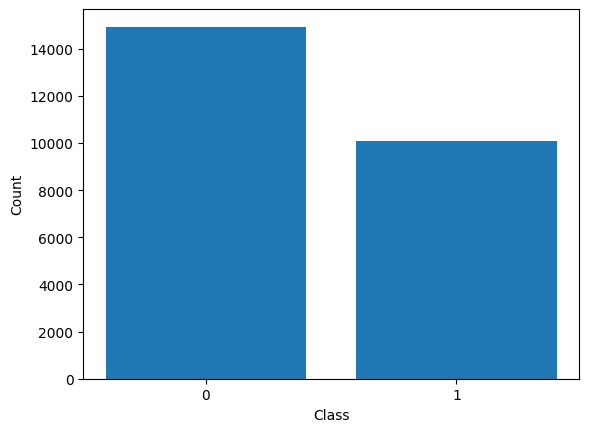

In [ ]:
#Summarize training dataset
counts=training_df['label'].value_counts()
plt.bar(counts.index, counts)
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

So what do the images from different calsses look like? Let's plot some of the images to finds out.

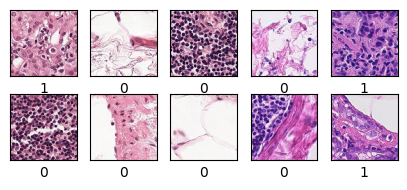

In [ ]:
#Plot 10 images from training dataset
plt.figure(figsize=(5,2))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(training_df['image'][i])
  plt.xlabel(training_df['label'][i])
plt.show()

I have no background in medical diagnosis or treatment, so the positive and negative images look pretty similar to me, but we will assume for now that the neural network will be able to pick up on the difference and move forward with the project.

Let's also split our training dataset into a training and a validation subset so we can monitor overfitting during the model building process.

In [ ]:
#split dataset and reformat to pass into model
train=training_df.sample(frac=0.8,random_state=5)
training_data=tf.stack(np.array(train['image']))
training_labels=tf.stack(np.array(train['label']))
val=training_df.drop(train.index)
validation_data=tf.stack(np.array(val['image']))
validation_labels=tf.stack(np.array(val['label']))
test_data=tf.stack(np.array(test_df['image']))

Lastly, it is worth highlighting a preprocessing step that is wrapped into the model. The image RGB values will also be rescaled between 0 and 1. This will help with weight convergance during SGD and also ensure colors on the lower spectrum of the RGB scale do not get overlooked. This could be done outside of the model, but that would require new images to be scaled before being passed into the model.

##Model Building

In this section we will construct the model which will consist of convolutional layers used for filtering/dimmensionality reduction and dense layers used for classification.

We will stick to the general architecture proposed by the Visual Geometry Group of Oxford in their 2015 conference paper (see sources section). Due to limited resources, the neural network built here will not be as deep, but will still follow the general template of stacking small 3x3 filters followed by maxpooling.

We will also do a little bit of hyperparemter tuning by experimenting with using dropout and batch normalization

In [ ]:
#Construct the Models

#Model 1: CNN with ADAM learning rate adjustment and no dropout
m1=Sequential([
    Rescaling(1./255, input_shape=(96,96,3)),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Model 2: CNN with ADAM learning rate adjustment and batch normalization
m2=Sequential([
    Rescaling(1./255, input_shape=(96,96,3)),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    BatchNormalization(axis=-1),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    BatchNormalization(axis=-1),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(axis=-1),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    BatchNormalization(axis=-1),
    Dense(128, activation='relu'),
    BatchNormalization(axis=-1),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Model 3: CNN with ADAM learning rate adjustment and dropout
m3=Sequential([
    Rescaling(1./255, input_shape=(96,96,3)),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    Dropout(rate=0.25),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Dropout(rate=0.25),
    MaxPool2D((2,2)),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Dropout(rate=0.25),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(64, activation='relu'),
    Dropout(rate=0.25),
    Dense(1, activation='sigmoid')
])

m1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
m2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
m3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
h1=m1.fit(training_data, training_labels,
           epochs=10,
           validation_data=(validation_data, validation_labels),
          batch_size=200,
          verbose=0)

h2=m2.fit(training_data, training_labels,
           epochs=10,
           validation_data=(validation_data, validation_labels),
          batch_size=200,
          verbose=0)

h3=m3.fit(training_data, training_labels,
           epochs=10,
           validation_data=(validation_data, validation_labels),
          batch_size=200,
          verbose=0)

## Results and Analysis

Let's plot the results for the training and validation layers

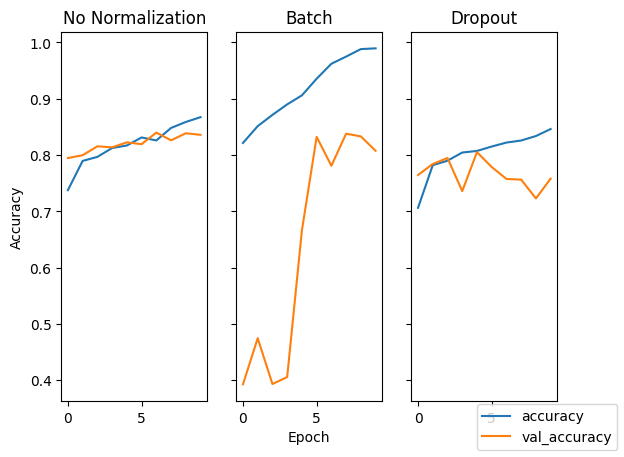

In [ ]:
#Accuracy Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
ax1.plot(h1.history['accuracy'])
ax1.plot(h1.history['val_accuracy'])
ax1.set_title('No Normalization')

ax2.plot(h2.history['accuracy'])
ax2.plot(h2.history['val_accuracy'])
ax2.set_title('Batch')

ax3.plot(h3.history['accuracy'])
ax3.plot(h3.history['val_accuracy'])
ax3.set_title('Dropout')

ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
fig.legend(['accuracy','val_accuracy'], loc='lower right')

Implementing batch normalization and dropout did not appear to have a positive impact on the model. The highest validation dataset accuracies were around 80% for all models. This would likely change at higher epochs, as it appears none of the models are fully optimized.

Now, we will make predictions on the test dataset and export the file for submission on Kaggle. The Kaggle submission will also give us an indication of how accurate the models are on images that they have not been trained or validated on.

In [ ]:
#Make predictions, format for submission, and export to CSV
p1=np.round(m1.predict(test_data)).ravel().astype(int).tolist()
id=test_df['id'].tolist()
m1df=pd.DataFrame({'id':id,'label':p1})
m1df.to_csv('cnn_no_normalization.csv', index=False)
files.download('cnn_no_normalization.csv')

p2=np.round(m2.predict(test_data)).ravel().astype(int).tolist()
m2df=pd.DataFrame({'id':id,'label':p2})
m2df.to_csv('cnn_batch_normalization.csv', index=False)
files.download('cnn_batch_normalization.csv')

p3=np.round(m3.predict(test_data)).ravel().astype(int).tolist()
m2df=pd.DataFrame({'id':id,'label':p3})
m2df.to_csv('cnn_dropout.csv', index=False)
files.download('cnn_dropout.csv')

1796/1796 [==============================] - 7s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1796/1796 [==============================] - 8s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1796/1796 [==============================] - 6s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here are the submission results. The model that encorperated dropout had slightly better results than the other models with an accuracy score of 78.4%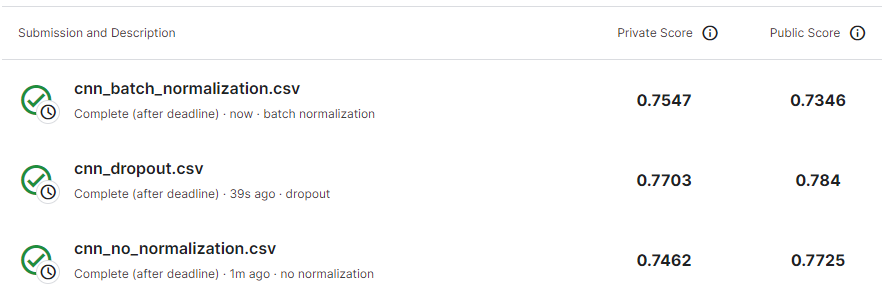

##Conclusion
A small CNN can be used somewhat successfully for binary classification of cancer tissue images. However, with a maximum accuracy of 78.4%, a larger, more accurate model would be required before it could be recommended for use in a clinical setting. The project was further limited by the lack of available GPU resources, which prevented training the model on the full dataset or using a larger number of epochs. For future work, I would try to secure more computational resources to build a larger model.

### Sources

https://www.tensorflow.org/tutorials/images/cnn

https://www.tensorflow.org/tutorials/images/classification

https://arxiv.org/abs/1409.1556

https://nchlis.github.io/2017_08_10/page.html